# 

In [1]:
from datetime import datetime
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import RobertaTokenizer
from collections import Counter
from sklearn.metrics import f1_score, recall_score, precision_score

import torch
from transformers import AutoConfig, AutoModelWithHeads
from transformers.trainer_utils import set_seed
from transformers import EvalPrediction
from transformers import AdapterTrainer
from transformers import TrainingArguments
from transformers import EarlyStoppingCallback


RANDOM_SEED = 42
set_seed(RANDOM_SEED)

dateTimeObj = datetime.now()
os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
approach = "epitome-training"

""" choose from the options: emotional-reactions, interpretations, explorations"""
adapter_name = 'emotional-reactions'


""" set your desired location for training output """
training_output_dir = f"./training_output/{approach}_{adapter_name}_{dateTimeObj.hour}{dateTimeObj.minute}-{dateTimeObj.day}-{dateTimeObj.month}"

# Data

In [3]:
""" 
decide which adapter to train and load data
"""
epitome = pd.read_csv(f'./epitome-data/{adapter_name}-reddit.csv')
epitome

,sp_id,rp_id,seeker_post,response_post,level,rationales
0,65m92s,dgbdk7z,Help. Help me. I dunno what I'm doing anymore,"That's pretty vague, do you not know what you'...",0,NaN
1,9ezsfi,e5t3oxh,I'm done saying I love you to her because I do...,idk what a Red pill means exactly but my advic...,0,NaN
2,6b2cmc,dhj8tcb,Always feel like I'm being criticized and mock...,"I think it's social anxiety , that creates par...",0,NaN
3,8iz0as,dyvq1ne,My diet becomes fucked when i get depressed.. ...,By any chance do you think you're in a loop. J...,0,NaN
4,aow3l9,eg40ecq,I hate not knowing why. I was diagnosed with d...,depression. not sadness which is caused by som...,0,NaN
...,...,...,...,...,...,...
3079,8jltcy,dz0kvhi,does anyone else keep forgetting stuff the nee...,"All day, every day. It's definitely not just y...",1,"All day, every day. It's definitely not just y..."
3080,94xc3o,e3ok8c0,What does depression feel like?. Honest questi...,like being stuck in a black hole. At times you...,0,NaN
3081,3zbq8e,cykvlsj,I'm to scared to commit suicide.. All I can fe...,I probably would have considered bringing harm...,0,NaN
3082,5kpp98,dbpqi2p,I just want to disappear but I don't want to h...,People barely notice me too,0,NaN


In [4]:
""" Make train/eval split """

pretrain_texts = list(epitome['response_post'].values)
pretrain_labels = list(epitome['level'].values)

train_texts, val_texts, train_labels, val_labels = train_test_split(pretrain_texts, pretrain_labels, test_size=.1)

In [5]:
""" encode response post text """

tokenizer = RobertaTokenizer.from_pretrained("roberta-base", padding="max_length")
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [6]:
""" show label distribution in train and val set"""

train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)

train_total = sum(train_label_counts.values())
val_total = sum(val_label_counts.values())
label_counts = {'label':[], 'train':[], 'dev':[]}

for lab in train_label_counts:
    train_prop = round(train_label_counts[lab] / train_total, 4) * 100
    val_prop = round(val_label_counts[lab] / val_total, 4) * 100
    
    label_counts['label'].append(lab)
    label_counts['train'].append(train_prop)
    label_counts['dev'].append(val_prop)
    
label_counts = pd.DataFrame(label_counts, columns=label_counts.keys()).sort_values(by=['train'], ascending=False)
label_counts

,label,train,dev
0,0,66.27,64.08
2,1,28.72,31.72
1,2,5.01,4.21


In [7]:
""" create torch dataset """

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)
id2label = {id: int(label) for (id, label) in enumerate(sorted(np.unique(train_dataset.labels)))}

# Adapter Training

In [8]:
""" init model """

config = AutoConfig.from_pretrained(
    "roberta-base",
    id2label=id2label,
)
model = AutoModelWithHeads.from_pretrained(
    "roberta-base",
    config=config,
)

/app/home/alahnala/miniconda3/envs/st/lib/python3.9/site-packages/transformers/adapters/models/roberta.py:250: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  warnings.warn(
/app/home/alahnala/miniconda3/envs/st/lib/python3.9/site-packages/transformers/adapters/models/roberta.py:228: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  warnings.warn(
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModelWithHeads: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModelWithHeads from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a B

In [9]:
""" create adapter with classification head and activate """

model.add_adapter(adapter_name)

model.add_classification_head(
    adapter_name,
    num_labels=3,
    id2label=id2label
  )

model.train_adapter(adapter_name)

In [10]:
""" set training arguments """

num_train_epochs=20
per_device_train_batch_size=8
per_device_eval_batch_size=8
metric_for_best_model='eval_f1_macro'
warmup_steps=1000
weight_decay=0.1
learning_rate=1e-04
early_stopping_patience=10
early_stopping_threshold=.005
callbacks=[]
callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)]
# callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience,
#                                 early_stopping_threshold=early_stopping_threshold)]


training_args = TrainingArguments(
    output_dir=training_output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    learning_rate=learning_rate,
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    logging_dir='./logs',
    logging_steps=50,
    eval_steps=50,
    save_steps=50,
    evaluation_strategy='steps',
    disable_tqdm=False,
    overwrite_output_dir=True,
    remove_unused_columns=False,
    save_strategy='steps',
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [11]:
""" create compute_metrics function """

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    
    metrics = {"accuracy": (preds == p.label_ids).mean()}  
    
    for avg in ['weighted', "macro"]:
        metrics[f"f1_{avg}"] = f1_score(p.label_ids, preds, average=avg)
        
    for id, lab in id2label.items():
        metrics[f"f1_{id2label[id]}"] = f1_score(p.label_ids, preds, average='micro', labels=[id])
    
    return metrics

In [12]:
""" init trainer """

trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=callbacks,
)

In [13]:
""" train """

trainer.train()

/app/home/alahnala/miniconda3/envs/st/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2775
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6940


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro,F1 0,F1 1,F1 2
50,1.146300,1.110520,0.042071,0.003397,0.026915,0.000000,0.000000,0.080745
100,1.070900,1.023623,0.640777,0.500488,0.260355,0.781065,0.000000,0.000000
150,0.967100,0.920111,0.640777,0.500488,0.260355,0.781065,0.000000,0.000000
200,0.885700,0.844712,0.640777,0.500488,0.260355,0.781065,0.000000,0.000000
250,0.823500,0.808060,0.640777,0.500488,0.260355,0.781065,0.000000,0.000000
300,0.789900,0.779988,0.640777,0.500488,0.260355,0.781065,0.000000,0.000000
350,0.708800,0.768778,0.640777,0.500488,0.260355,0.781065,0.000000,0.000000
400,0.721400,0.747500,0.640777,0.500488,0.260355,0.781065,0.000000,0.000000
450,0.726200,0.683300,0.650485,0.534767,0.293775,0.788732,0.092593,0.000000
500,0.680000,0.617693,0.750809,0.741733,0.498084,0.827586,0.666667,0.000000


***** Running Evaluation *****
  Num examples = 309
  Batch size = 8
Saving model checkpoint to ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-50
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-50/emotional-reactions/adapter_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-50/emotional-reactions/pytorch_adapter.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-50/emotional-reactions/head_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-50/emotional-reactions/pytorch_model_head.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-50/emotional-reactions/head_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-50/emotional-rea

Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-350/emotional-reactions/pytorch_adapter.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-350/emotional-reactions/head_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-350/emotional-reactions/pytorch_model_head.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-350/emotional-reactions/head_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-350/emotional-reactions/pytorch_model_head.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-350/emotional-reactions/head_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-350/emotional-reactions/pytorch_model_head

Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-650/emotional-reactions/pytorch_model_head.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-650/emotional-reactions/head_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-650/emotional-reactions/pytorch_model_head.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-650/emotional-reactions/head_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-650/emotional-reactions/pytorch_model_head.bin
***** Running Evaluation *****
  Num examples = 309
  Batch size = 8
Saving model checkpoint to ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-700
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-700/

Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-950/emotional-reactions/pytorch_model_head.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-950/emotional-reactions/head_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-950/emotional-reactions/pytorch_model_head.bin
***** Running Evaluation *****
  Num examples = 309
  Batch size = 8
Saving model checkpoint to ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1000
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1000/emotional-reactions/adapter_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1000/emotional-reactions/pytorch_adapter.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1

Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1250/emotional-reactions/pytorch_model_head.bin
***** Running Evaluation *****
  Num examples = 309
  Batch size = 8
Saving model checkpoint to ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1300
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1300/emotional-reactions/adapter_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1300/emotional-reactions/pytorch_adapter.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1300/emotional-reactions/head_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1300/emotional-reactions/pytorch_model_head.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoin

  Batch size = 8
Saving model checkpoint to ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1600
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1600/emotional-reactions/adapter_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1600/emotional-reactions/pytorch_adapter.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1600/emotional-reactions/head_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1600/emotional-reactions/pytorch_model_head.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1600/emotional-reactions/head_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1600/emotional-reactions/pytorch_model_head.bin
Configur

Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1900/emotional-reactions/pytorch_adapter.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1900/emotional-reactions/head_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1900/emotional-reactions/pytorch_model_head.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1900/emotional-reactions/head_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1900/emotional-reactions/pytorch_model_head.bin
Configuration saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1900/emotional-reactions/head_config.json
Module weights saved in ./training_output/epitome-training_emotional-reactions_1536-21-4/checkpoint-1900/emotional-reactions/pytorch_mod

TrainOutput(global_step=2000, training_loss=0.5272480578422546, metrics={'train_runtime': 174.4239, 'train_samples_per_second': 318.19, 'train_steps_per_second': 39.788, 'total_flos': 4281472923356160.0, 'train_loss': 0.5272480578422546, 'epoch': 5.76})

# Evaluate

In [14]:
""" evaluate best checkpoint (loaded at end of training) """

trainer.model.cuda()
eval_output = trainer.evaluate()
eval_metric_result = eval_output[metric_for_best_model]
pd.DataFrame({'metric':list(eval_output.keys()), 'value': list(eval_output.values())}, columns=['metric', 'value'])

***** Running Evaluation *****
  Num examples = 309
  Batch size = 8


,metric,value
0,eval_loss,0.489088
1,eval_accuracy,0.844660
2,eval_f1_weighted,0.845938
3,eval_f1_macro,0.853899
4,eval_f1_0,0.882653
5,eval_f1_1,0.762376
6,eval_f1_2,0.916667
7,eval_runtime,1.056800
8,eval_samples_per_second,292.384000
9,eval_steps_per_second,36.903000


***** Running Prediction *****
  Num examples = 309
  Batch size = 8


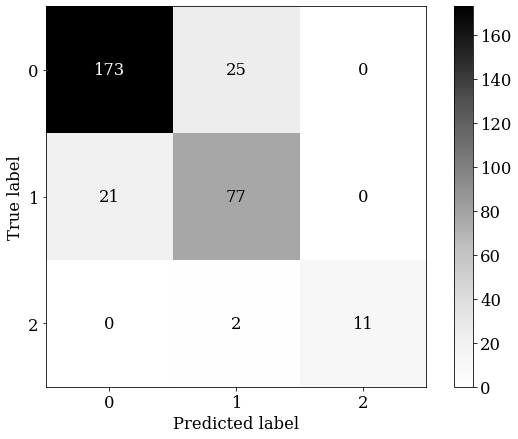

In [15]:
""" plot confusion matrix of dev set predictions """

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size': 16.4,
    'figure.figsize': [10,7]
})



p = trainer.predict(val_dataset)
preds = np.argmax(p.predictions, axis=1)

cm = confusion_matrix(p.label_ids, preds, labels=[0,1,2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[id2label[i] for i in range(3)])

disp.plot(cmap='Greys')
plt.show()

# Optional - save adapter

In [16]:
""" set path for where to save the adapter """
adapter_save_path = f"./trained_adapters/{adapter_name}"

""" save """
trainer.model.save_adapter(adapter_save_path, adapter_name)

Configuration saved in ./trained_adapters/emotional-reactions/adapter_config.json
Module weights saved in ./trained_adapters/emotional-reactions/pytorch_adapter.bin
Configuration saved in ./trained_adapters/emotional-reactions/head_config.json
Module weights saved in ./trained_adapters/emotional-reactions/pytorch_model_head.bin
